In [1]:
import sys
import pickle as pkl
import torch

from tqdm import tqdm

sys.path.append("../utils")

from surface_analyzer import *
from utils import *

test_targets = pkl.load(open('test_targs3.pkl','rb'))
test_preds = pkl.load(open('test_preds3.pkl','rb'))
test_ids = pkl.load(open('test_ids3.pkl','rb'))

#predict_test_targets = pkl.load(open('predict_test_targs.pkl','rb'))
#predict_test_preds = pkl.load(open('predict_test_preds.pkl','rb'))
#predict_test_ids = pkl.load(open('predict_test_ids.pkl','rb'))

bulk_data = pkl.load(open('../data_raw/all_combined_clean_surface_and_bulk_no_benchmark_newref.pkl','rb'))

In [2]:
count=0
for key in bulk_data:
    
    try:
        surf = Surface.objects.get(id=key)
        count+=1
    except:
        pass

In [3]:
count*0.6

5820.599999999999

In [4]:
jc = JobConfig.objects.get(name='pbe_u_paw_spinpol_opt_surf_vasp')
my_surfaces = Surface.objects.filter(parentjob__config=jc, converged=True)

jc = JobConfig.objects.get(name='pbe_u_paw_spinpol_opt_surf_vasp')
my_bulk = Crystal.objects.filter(parentjob__config=jc, converged=True)

In [5]:
def get_metal_surface_sites(surface):

    surface_sites = get_surface_sites(surface)
    atomic_numbers = np.array(surface.xyz)[:,0].tolist()
    atomic_symbols = [Element.from_Z(z).symbol for z in atomic_numbers]

    metal_surface_sites=[]
    for surface_site in surface_sites:
        if np.array(atomic_symbols)[surface_site] != 'O':
            metal_surface_sites.append(surface_site)

    return metal_surface_sites

In [6]:
def get_bulk_B_sites(bulk, B):

    atomic_numbers = np.array(bulk.xyz)[:,0].tolist()
    atomic_symbols = [Element.from_Z(z).symbol for z in atomic_numbers]
    return np.where([symbol==B for symbol in atomic_symbols])[0]

100%|██████████| 3058/3058 [00:33<00:00, 91.03it/s] 


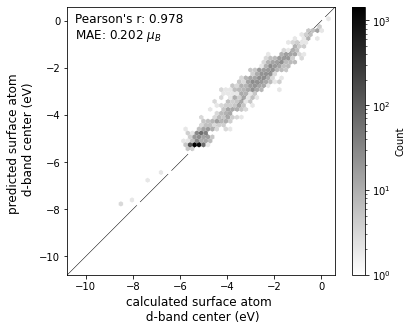

In [7]:
# only surface metal atoms

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        surface = Surface.objects.get(id=id_)
        M_surface_sites = get_metal_surface_sites(surface)
        
    except:
        pass
    else:
        
        if surface in my_surfaces:

            # magmoms
            targ = np.array(test_targets[index])[:,2]#.numpy()
            pred = np.array(test_preds[index])[:,2]#.numpy()

            site_targs.append(np.array(targ)[M_surface_sites])
            site_preds.append(np.array(pred)[M_surface_sites])

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]
_, _, ax, _ = plot_hexbin(np.array(site_targs)[indexes], np.array(site_preds)[indexes], 'magmom', bins='log', cmap='gray_r')

plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.savefig('parity_dband_surface.pdf')

plt.show()



100%|██████████| 3058/3058 [00:27<00:00, 113.00it/s]


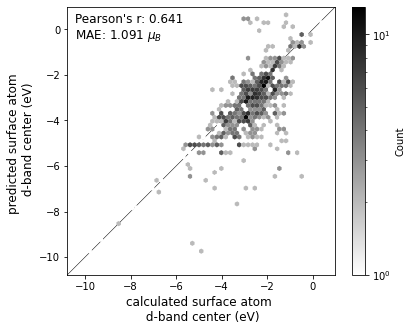

In [8]:
# only surface metal atoms

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        surface = Surface.objects.get(id=id_)
        bulk = surface.bulk
        M_surface_sites = get_metal_surface_sites(surface)
        
    except:
        pass
    else:
        
        if surface in my_surfaces and bulk is not None and bulk.id in bulk_data.keys():
    

            # magmoms
            targ = np.array(test_targets[index])[:,2][M_surface_sites]
            
            atomic_numbers = np.array(surface.xyz)[:,0].tolist()
            atomic_symbols = np.array([Element.from_Z(z).symbol for z in atomic_numbers])[M_surface_sites]

            pred_all = np.array(bulk_data[bulk.id].site_properties['bandcenter'])
            pred = []
            
            for atomic_symbol in atomic_symbols:
                indexes = get_bulk_B_sites(bulk, atomic_symbol)
                pred.append(np.mean(pred_all[indexes]))
            

            site_targs.append(targ)
            site_preds.append(pred)

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]
_, _, ax, _ = plot_hexbin(np.array(site_targs)[indexes], np.array(site_preds)[indexes], 'magmom', bins='log', cmap='gray_r')

plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.show()




In [9]:
import pickle as pkl
fit_values = pkl.load(open('../results_bulk/fit_values_bandcenter.pkl','rb'))

  0%|          | 0/3058 [00:00<?, ?it/s]/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:4121: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:3924: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
  2%|▏         | 73/3058 [00:02<01:26, 34.36it/s]/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 3058/3058 [01:59<00:00, 25

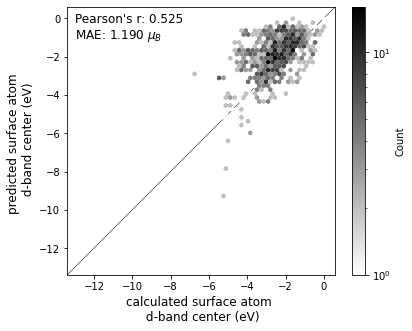

In [10]:
# only surface metal atoms
from pymatgen.analysis.local_env import *
cn = CrystalNN()

x = []
y = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        surface = Surface.objects.get(id=id_)
        bulk = surface.bulk
        M_surface_sites = get_metal_surface_sites(surface)
        
    except:
        pass
    else:
        
        if surface in my_surfaces and bulk is not None and bulk.id in bulk_data.keys():
            
            struct = bulk_data[id_]
            
            for index in M_surface_sites:
        
                site1 = struct.sites[index]
                symbol1 = list(site1.species.as_dict().keys())[0]
        
                bandcenter = struct.site_properties['bandcenter'][index]
        
                # get symbol set for the given site
                symbol_set_site = []
                neighbors = cn.get_nn_info(struct, index)
        
                dist = []
                for n in neighbors:
                    site2 = n['site']
                    symbol2 = list(site2.species.as_dict().keys())[0]
                    symbol_set_site.append(symbol1+symbol2)
                    dist.append(site2.distance(site1))
            
                n = len(dist)
                d = np.mean(dist)
        
                # check that there's only one type of interaction for this site
                pred=0
                for i in range(len(dist)):
            
                    symbol = symbol_set_site[i]
            
                    if symbol in fit_values.keys():
                
                        Ro = fit_values[symbol]['Ro']
                        b = fit_values[symbol]['b']
                        pred+=exp((Ro-dist[i])/b)
                    
                    else:
                        pred+=np.nan
                 
                x.append(pred)
                y.append(bandcenter)

site_targs = y
site_preds = x



indexes_finite = np.where(np.isfinite(np.array(site_preds)))[0]
indexes_no_nan = np.where(~np.isnan(np.array(site_preds)))[0]
indexes = np.intersect1d(indexes_finite, indexes_no_nan)

site_targs = np.array(site_targs)[indexes]
site_preds = np.array(site_preds)[indexes]

        
_, _, ax, _ = plot_hexbin(site_targs, -1*site_preds, 'magmom', bins='log', cmap='gray_r')


plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.show()

100%|██████████| 3058/3058 [00:24<00:00, 122.33it/s]


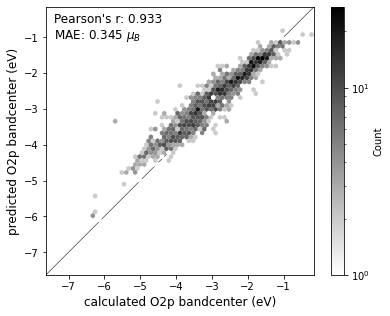

In [11]:
# only surface oxygen

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        surface = Surface.objects.get(id=id_)
        O_surface_sites = get_O_surface_sites(surface)
        
    except:
        pass
    else:
        
        if surface in my_surfaces:
            

            # magmoms
            targ = np.array(test_targets[index])[:,2]#.numpy()
            pred = np.array(test_preds[index])[:,2]#.numpy()

            site_targs.append(np.array(targ)[O_surface_sites])
            site_preds.append(np.array(pred)[O_surface_sites])

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]
_, _, ax, _ = plot_hexbin(np.array(site_targs)[indexes], np.array(site_preds)[indexes], 'magmom', bins='log', cmap='gray_r')

plt.xlabel('calculated O2p bandcenter (eV)')
plt.ylabel('predicted O2p bandcenter (eV)')

plt.savefig('parity_O2pband_surface.pdf')

plt.show()




100%|██████████| 3058/3058 [00:26<00:00, 115.00it/s]


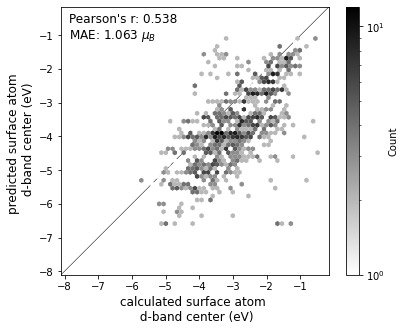

In [12]:
# only surface metal atoms

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        surface = Surface.objects.get(id=id_)
        bulk = surface.bulk
        O_surface_sites = get_O_surface_sites(surface)
        
    except:
        pass
    else:
        
        if surface in my_surfaces and bulk is not None and bulk.id in bulk_data.keys():
            

            # magmoms
            targ = np.array(test_targets[index])[:,2][O_surface_sites]
            
            atomic_numbers = np.array(surface.xyz)[:,0].tolist()
            atomic_symbols = np.array([Element.from_Z(z).symbol for z in atomic_numbers])[O_surface_sites]

            pred_all = np.array(bulk_data[bulk.id].site_properties['bandcenter'])
            pred = []
            
            for atomic_symbol in atomic_symbols:
                indexes = get_bulk_B_sites(bulk, atomic_symbol)
                pred.append(np.mean(pred_all[indexes]))
            

            site_targs.append(targ)
            site_preds.append(pred)

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]
_, _, ax, _ = plot_hexbin(np.array(site_targs)[indexes], np.array(site_preds)[indexes], 'magmom', bins='log', cmap='gray_r')

plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.show()





  0%|          | 0/3058 [00:00<?, ?it/s]/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:4121: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:3924: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
 18%|█▊        | 558/3058 [00:31<03:32, 11.78it/s]/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 3058/3058 [03:14<00:00, 1

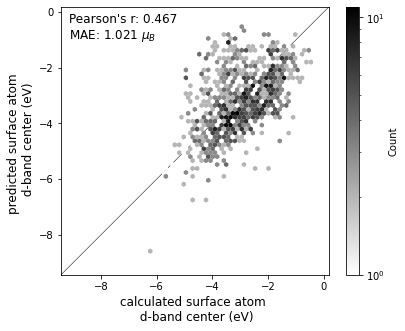

In [13]:
# only surface metal atoms

x = []
y = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        surface = Surface.objects.get(id=id_)
        bulk = surface.bulk
        M_surface_sites = get_O_surface_sites(surface)
        
    except:
        pass
    else:
        
        if surface in my_surfaces and bulk is not None and bulk.id in bulk_data.keys():
            
            struct = bulk_data[id_]
            
            for index in M_surface_sites:
        
                site1 = struct.sites[index]
                symbol1 = list(site1.species.as_dict().keys())[0]
        
                bandcenter = struct.site_properties['bandcenter'][index]
        
                # get symbol set for the given site
                symbol_set_site = []
                neighbors = cn.get_nn_info(struct, index)
        
                dist = []
                for n in neighbors:
                    site2 = n['site']
                    symbol2 = list(site2.species.as_dict().keys())[0]
                    symbol_set_site.append(symbol1+symbol2)
                    dist.append(site2.distance(site1))
            
                n = len(dist)
                d = np.mean(dist)
        
                # check that there's only one type of interaction for this site
                pred=0
                for i in range(len(dist)):
            
                    symbol = symbol_set_site[i]
            
                    if symbol in fit_values.keys():
                
                        Ro = fit_values[symbol]['Ro']
                        b = fit_values[symbol]['b']
                        pred+=exp((Ro-dist[i])/b)
                    
                    else:
                        pred+=np.nan
                 
                x.append(pred)
                y.append(bandcenter)

site_targs = y
site_preds = x



indexes_finite = np.where(np.isfinite(np.array(site_preds)))[0]
indexes_no_nan = np.where(~np.isnan(np.array(site_preds)))[0]
indexes = np.intersect1d(indexes_finite, indexes_no_nan)

site_targs = np.array(site_targs)[indexes]
site_preds = np.array(site_preds)[indexes]

        
_, _, ax, _ = plot_hexbin(site_targs, -1*site_preds, 'magmom', bins='log', cmap='gray_r')


plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.show()

In [14]:
'''

fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(np.array(site_targs)[indexes], np.array(site_preds)[indexes], color='k', alpha=0.05)
plt.scatter(np.array(site_targs_pred)[indexes_pred], np.array(site_preds_pred)[indexes_pred], color='r')

xlim = ax.get_xlim()
plt.plot(xlim, xlim, zorder=-100, color='k', linewidth=1)

plt.scatter([-2.2528207],[-2.31344], color='#eebebc', s=80, edgecolor='w', linewidth=1.5)
plt.scatter([-1.9458221], [-2.1477265], color='#f1cbc9', s=80, edgecolor='w', linewidth=1.5)
plt.scatter([-3.781158], [-3.1810598], color='#6e3e3c', s=80, edgecolor='w', linewidth=1.5)
plt.scatter([-1.8325659, -1.8600941, -1.8299662], [-1.958406,  -1.9711652, -1.9583423], color='#fcf2f2', s=80,
           edgecolor='w', linewidth=1.5, zorder=10)

#xlim=[-2,-1]
plt.xlim(xlim)
plt.ylim(xlim)


#plt.savefig('parity_surface_O2p.pdf')
'''

"\n\nfig, ax = plt.subplots(figsize=(4,4))\n\nplt.scatter(np.array(site_targs)[indexes], np.array(site_preds)[indexes], color='k', alpha=0.05)\nplt.scatter(np.array(site_targs_pred)[indexes_pred], np.array(site_preds_pred)[indexes_pred], color='r')\n\nxlim = ax.get_xlim()\nplt.plot(xlim, xlim, zorder=-100, color='k', linewidth=1)\n\nplt.scatter([-2.2528207],[-2.31344], color='#eebebc', s=80, edgecolor='w', linewidth=1.5)\nplt.scatter([-1.9458221], [-2.1477265], color='#f1cbc9', s=80, edgecolor='w', linewidth=1.5)\nplt.scatter([-3.781158], [-3.1810598], color='#6e3e3c', s=80, edgecolor='w', linewidth=1.5)\nplt.scatter([-1.8325659, -1.8600941, -1.8299662], [-1.958406,  -1.9711652, -1.9583423], color='#fcf2f2', s=80,\n           edgecolor='w', linewidth=1.5, zorder=10)\n\n#xlim=[-2,-1]\nplt.xlim(xlim)\nplt.ylim(xlim)\n\n\n#plt.savefig('parity_surface_O2p.pdf')\n"

100%|██████████| 3058/3058 [00:23<00:00, 129.76it/s]


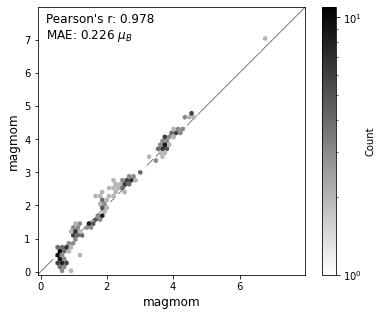

In [15]:
# only surface oxygen

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        surface = Surface.objects.get(id=id_)
        surface_sites = get_surface_sites(surface)
        
        if surface in my_surfaces:
            

            # magmoms
            targ = np.array(test_targets[index])[:,0]#.numpy()
            pred = np.array(test_preds[index])[:,0]#.numpy()

            site_targs.append(np.array(targ)[surface_sites])
            site_preds.append(np.array(pred)[surface_sites])
            
    except:
        pass
                              
site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]

site_targs_nonzero = []
site_preds_nonzero = []

for i in indexes:
    if site_targs[i] > 0.5:
        site_targs_nonzero.append(site_targs[i])
        site_preds_nonzero.append(site_preds[i])
        
_, _, ax, _ = plot_hexbin(site_targs_nonzero, site_preds_nonzero, 'magmom', bins='log', cmap='gray_r')


plt.xlabel('magmom')
plt.ylabel('magmom')

plt.savefig('parity_magmom_surface.pdf')

plt.show()





100%|██████████| 3058/3058 [00:25<00:00, 120.87it/s]


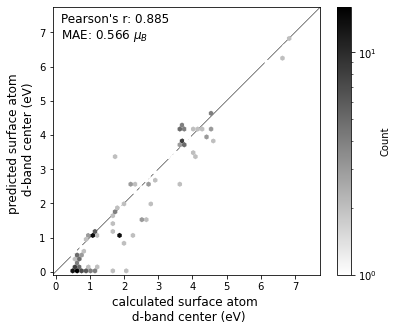

In [16]:
# only surface metal atoms

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        surface = Surface.objects.get(id=id_)
        bulk = surface.bulk
        surface_sites = get_surface_sites(surface)
    
        
        if surface in my_surfaces and bulk is not None and bulk.id in bulk_data.keys():
            

            # magmoms
            targ = np.array(test_targets[index])[:,0][surface_sites]
            
            atomic_numbers = np.array(surface.xyz)[:,0].tolist()
            atomic_symbols = np.array([Element.from_Z(z).symbol for z in atomic_numbers])[surface_sites]

            pred_all = np.array(bulk_data[bulk.id].site_properties['magmom'])
            pred = []
            
            for atomic_symbol in atomic_symbols:
                indexes = get_bulk_B_sites(bulk, atomic_symbol)
                pred.append(np.mean(pred_all[indexes]))
            

            site_targs.append(targ)
            site_preds.append(pred)
            
    except:
        pass

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]

site_targs_nonzero = []
site_preds_nonzero = []

for i in indexes:
    if site_targs[i] > 0.5:
        site_targs_nonzero.append(site_targs[i])
        site_preds_nonzero.append(site_preds[i])
        
_, _, ax, _ = plot_hexbin(site_targs_nonzero, site_preds_nonzero, 'magmom', bins='log', cmap='gray_r')


plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.show()






100%|██████████| 3058/3058 [00:23<00:00, 132.67it/s]


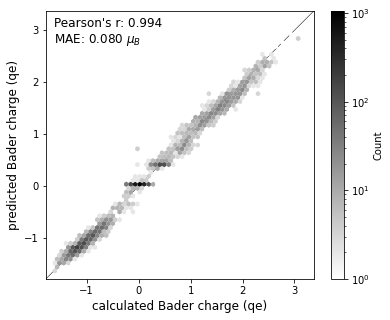

In [17]:
# only surface oxygen

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        surface = Surface.objects.get(id=id_)
        surface_sites = get_surface_sites(surface)
        
        if surface in my_surfaces:
            
            #O_surface_sites = get_O_surface_sites(surface)

            # magmoms
            targ = np.array(test_targets[index])[:,1]#.numpy()
            pred = np.array(test_preds[index])[:,1]#.numpy()

            site_targs.append(np.array(targ)[surface_sites])
            site_preds.append(np.array(pred)[surface_sites])
            
    except:
        pass

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]
_, _, ax, _ = plot_hexbin(np.array(site_targs)[indexes], np.array(site_preds)[indexes], 'magmom', bins='log', cmap='gray_r')

plt.xlabel('calculated Bader charge (qe)')
plt.ylabel('predicted Bader charge (qe)')

plt.savefig('parity_Bader.pdf')

plt.show()





In [ ]:
plt.scatter(site_targs, -1*site_preds)